# Functions & Imports

In [1]:
import re

In [2]:
# results folder
results_folder = 'results/'

In [3]:
def average_commit_and_abort_rate(file_path):
    """
    Parse an Aria/YCSB log that contains *10* runs and return:
        1) the mean of the 'total commit:' values
        2) the mean abort-rate across runs
           (abort-rate_i = average_abort_i / (average_commit_i + average_abort_i))
    Raises ValueError if it can’t find exactly 10 runs.
    """
    total_commits = []
    abort_rates   = []

    # e.g. "total commit: 29394"
    total_commit_re = re.compile(r'total commit:\s*([0-9.]+)')

    # e.g. "average commit: 29394 abort: 823.5 ..."
    avg_line_re = re.compile(
        r'average commit:\s*([0-9.]+)\s+abort:\s*([0-9.]+)'
    )

    with open(file_path, 'r') as f:
        for line in f:
            m_tot = total_commit_re.search(line)
            if m_tot:
                total_commits.append(float(m_tot.group(1)))
                continue            # total line never also matches avg regex

            m_avg = avg_line_re.search(line)
            if m_avg:
                commit = float(m_avg.group(1))
                abort  = float(m_avg.group(2))
                abort_rate = abort / (commit + abort) if (commit + abort) else 0
                abort_rates.append(abort_rate)

    # sanity-check: expect 10 runs
    if len(total_commits) != 10 or len(abort_rates) != 10:
        raise ValueError(
            f"Expected 10 runs, found {len(total_commits)} total-commit lines "
            f"and {len(abort_rates)} average-commit lines."
        )

    avg_commit      = sum(total_commits) / 10
    avg_abort_rate  = sum(abort_rates)  / 10    # still a fraction, e.g. 0.27

    return avg_commit, avg_abort_rate

In [6]:
import matplotlib.pyplot as plt
import os

# Assumes this function is already defined elsewhere
# from your_module import average_commit_and_abort_rate

def plot_vs_contention_level(batch_method, results_folder='./results/', contention_levels=None):
    """
    Plots throughput and abort rate vs. contention level for a given batch method.

    Parameters:
    - batch_method: str, e.g., "partition_coordinator_batching" or "read_write_sum_batching"
    - results_folder: str, path to folder containing result .txt files
    - contention_levels: list of str, e.g., ['low_contention', 'medium_contention', 'high_contention']
    """
    if contention_levels is None:
        contention_levels = ['low_contention', 'medium_contention', 'high_contention']
    
    if batch_method == "baseline":
        batch_title = "Baseline"
        batch_folder = ""
    else:
        batch_title = "Partition Coordinator Batching" if batch_method == "partition_coordinator_batching" else "Read-Write Sum Batching"
        batch_folder = "partitionCoordinatorBatching" if batch_method == "partition_coordinator_batching" else "readWriteSum"

    throughput = []
    abort_rate = []
    labels = []

    for level in contention_levels:
        filename = f"{level}_{batch_method}.txt"
        filepath = os.path.join(results_folder, batch_folder, filename)
        try:
            average_commit, avg_abort_rate = average_commit_and_abort_rate(filepath)
            throughput.append(average_commit)
            abort_rate.append(avg_abort_rate * 100)  # convert to percent
            labels.append(level.replace('_contention', '').capitalize())  # Clean label for plot
            print(f"{level} - Throughput: {average_commit:.2f}, Abort Rate: {avg_abort_rate:.2%}")
        except FileNotFoundError:
            print(f"Warning: File {filepath} not found. Skipping.")
            continue

    # Plot: Throughput vs. Contention Level
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(labels, throughput, marker='o', color='blue')
    plt.title(f'Throughput vs. Contention Level\n({batch_title})')
    plt.xlabel('Contention Level')
    plt.ylabel('Throughput (commits/sec)')
    plt.grid(True)

    # Plot: Abort Rate vs. Contention Level
    plt.subplot(1, 2, 2)
    plt.plot(labels, abort_rate, marker='x', color='red')
    plt.title(f'Abort Rate (%) vs. Contention Level\n({batch_title})')
    plt.xlabel('Contention Level')
    plt.ylabel('Abort Rate (%)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_vs_contention_level(batch_method="partition_coordinator_batching")


In [5]:
def average_p99_latency(log_file_path):
    """
    Computes the average P99 latency across 10 runs.
    For each run:
      - Averages the P99 latency across 4 workers.
    Then:
      - Averages those 10 run-level averages to get the final value.

    Parameters:
    - log_file_path: str, path to the log file containing output from all 10 runs

    Returns:
    - float: Final average P99 latency in microseconds
    """
    run_averages = []
    current_run_latencies = []

    # Regex to match lines with worker latency
    latency_pattern = re.compile(r'Worker \d+ latency: .*?(\d+)\s+us\s+\(99%\)')

    with open(log_file_path, 'r') as f:
        for line in f:
            match = latency_pattern.search(line)
            if match:
                p99_us = int(match.group(1))
                current_run_latencies.append(p99_us)

                # When we've seen 4 workers, finish the run
                if len(current_run_latencies) == 4:
                    run_avg = sum(current_run_latencies) / 4
                    run_averages.append(run_avg)
                    current_run_latencies = []

    if len(run_averages) != 10:
        print(f"Warning: Expected 10 runs, but found {len(run_averages)}")

    final_avg = sum(run_averages) / len(run_averages) if run_averages else None
    return final_avg

In [6]:
def plot_p99_latency_vs_contention_level(
    batch_method,
    contention_levels=None,
    results_folder='./results/'
):
    """
    Plots average P99 latency vs. contention level for a given batch size.

    Parameters:
    - batch_method: str, e.g., "partition_coordinator_batching" or "read_write_sum_batching"
    - contention_levels: list of str, e.g., ['low_contention', 'medium_contention', ...]
    - results_folder: str, base directory of result files
    """
    if contention_levels is None:
        contention_levels = ['low_contention', 'medium_contention', 'high_contention', 'extreme_contention']

    batch_title = "Partition Coordinator Batching" if batch_method == "partition_coordinator_batching" else "Read-Write Sum Batching"
    batch_folder = "partitionCoordinatorBatching" if batch_method == "partition_coordinator_batching" else "readWriteSum"

    avg_latencies = []
    labels = []

    for level in contention_levels:
        filename = f"{level}_{batch_method}.txt"
        filepath = os.path.join(results_folder, batch_folder, filename)
        try:
            avg_p99 = average_p99_latency(filepath)
            avg_latencies.append(avg_p99)
            labels.append(level.replace('_contention', '').capitalize())
            print(f"{level} - Average P99 latency: {avg_p99:.2f} us")
        except FileNotFoundError:
            print(f"Warning: File {filepath} not found. Skipping.")

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(labels, avg_latencies, marker='o', color='darkgreen')
    plt.title(f'Average P99 Latency vs. Contention Level\n({batch_title})')
    plt.xlabel('Contention Level')
    plt.ylabel('Average P99 Latency (us)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Baselines

## Throughput and Abort Rate

low_contention - Throughput: 39388.22, Abort Rate: 4.37%
medium_contention - Throughput: 28469.61, Abort Rate: 30.38%
high_contention - Throughput: 43856.62, Abort Rate: 81.77%


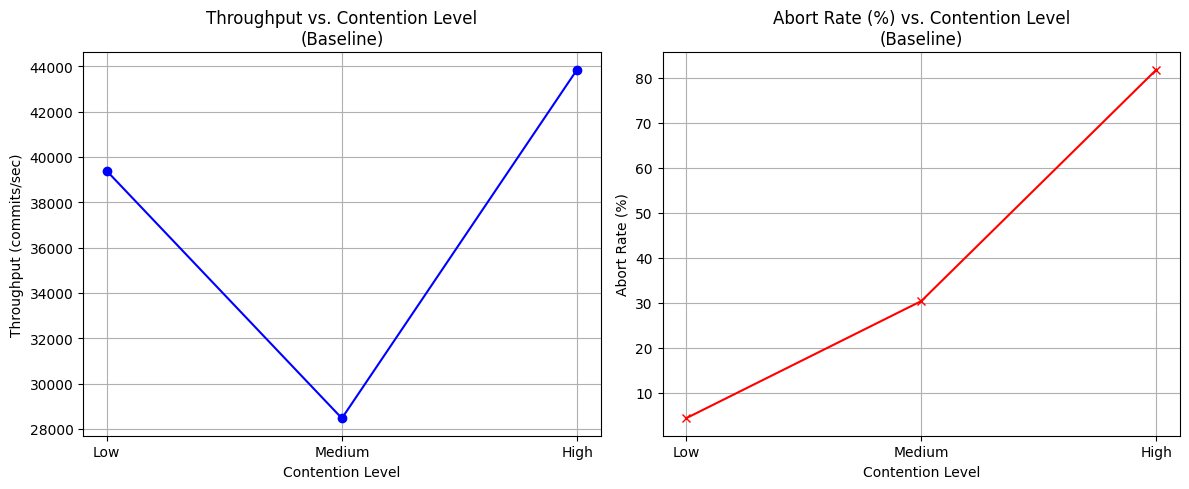

low_contention - Throughput: 19803.19, Abort Rate: 1.50%
medium_contention - Throughput: 15771.30, Abort Rate: 15.66%
high_contention - Throughput: 11663.99, Abort Rate: 35.36%
extreme_contention - Throughput: 7038.36, Abort Rate: 65.14%


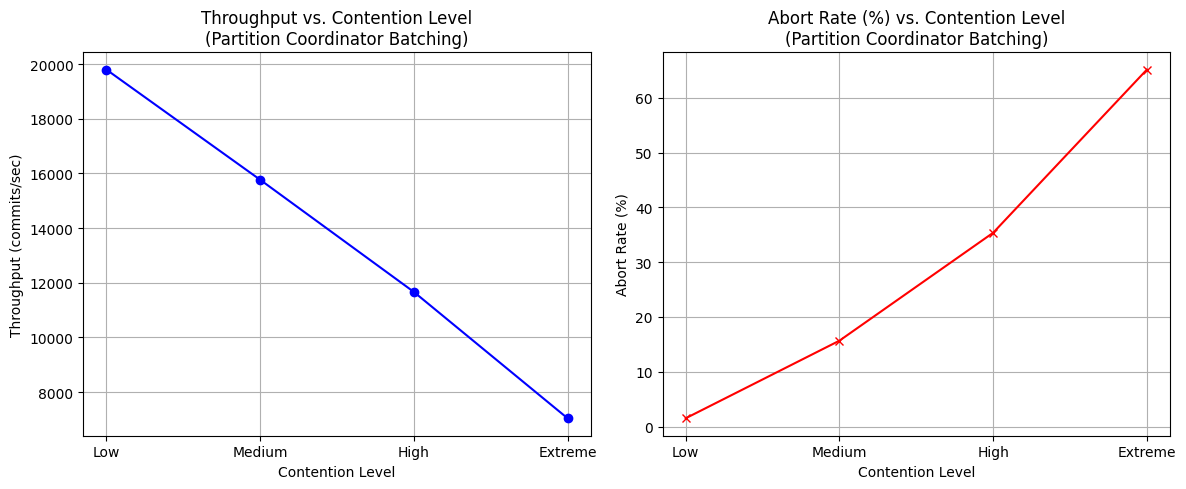

low_contention - Throughput: 18390.96, Abort Rate: 1.48%
medium_contention - Throughput: 16373.42, Abort Rate: 15.66%
high_contention - Throughput: 11778.47, Abort Rate: 35.42%
extreme_contention - Throughput: 6238.07, Abort Rate: 65.13%


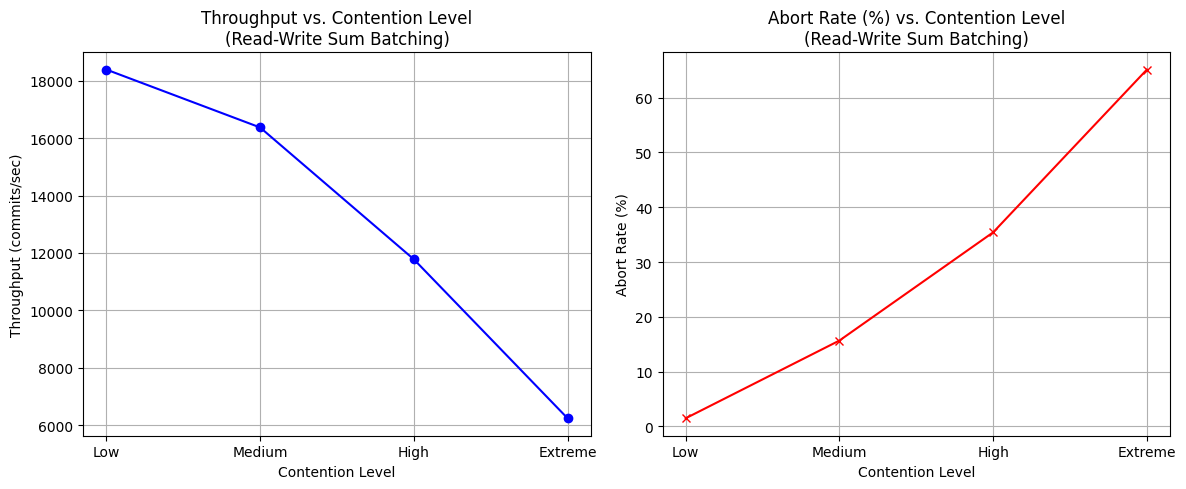

In [ ]:
plot_vs_contention_level(batch_method="baseline", contention_levels=['low_contention', 'medium_contention', 'high_contention', 'extreme_contention'])

# e.g. expected results file: high_contention_partition_coordinator_batching.txt
plot_vs_contention_level(batch_method="partition_coordinator_batching", contention_levels=['low_contention', 'medium_contention', 'high_contention', 'extreme_contention'])

# e.g. expected results file: high_contention_read_write_sum_batching.txt
plot_vs_contention_level(batch_method="read_write_sum_batching_15", contention_levels=['low_contention', 'medium_contention', 'high_contention', 'extreme_contention'])

## Latency

low_contention - Average P99 latency: 143411.25 us
medium_contention - Average P99 latency: 149845.30 us
high_contention - Average P99 latency: 145016.23 us
extreme_contention - Average P99 latency: 133817.02 us


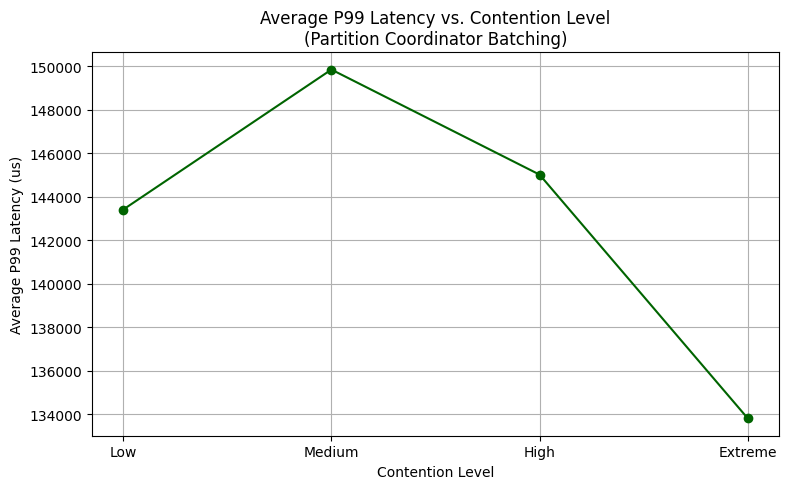

low_contention - Average P99 latency: 148875.40 us
medium_contention - Average P99 latency: 142674.30 us
high_contention - Average P99 latency: 142275.75 us
extreme_contention - Average P99 latency: 143808.48 us


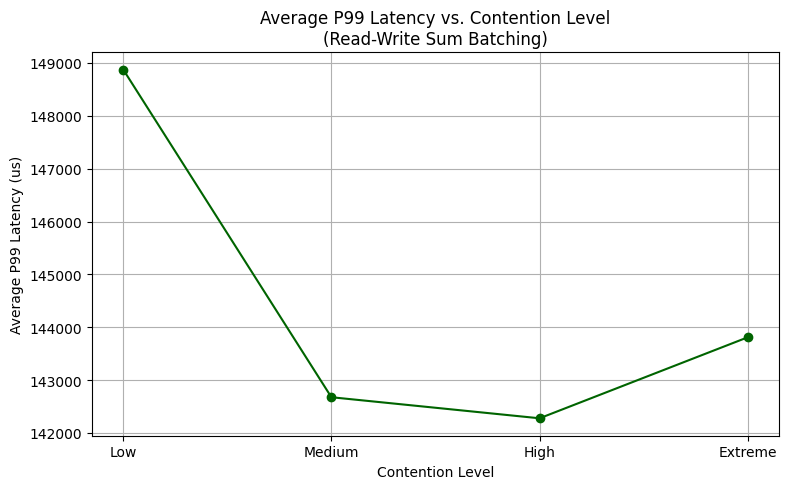

In [8]:
plot_p99_latency_vs_contention_level(
    batch_method="partition_coordinator_batching",
    contention_levels=['low_contention', 'medium_contention', 'high_contention', 'extreme_contention']
)

plot_p99_latency_vs_contention_level(
    batch_method="read_write_sum_batching_15",
    contention_levels=['low_contention', 'medium_contention', 'high_contention', 'extreme_contention']
)

# Comparing Baselines to Experiments

In [9]:

def plot_metrics_vs_contention_levels_multiple(
    thresholds=['10', '15', '20'],
    results_folder='./results/readWriteSum',
    contention_levels=None
):
    if contention_levels is None:
        contention_levels = ['low_contention', 'medium_contention', 'high_contention', 'extreme_contention']

    x_labels = [level.replace('_contention', '').capitalize() for level in contention_levels]

    # Use 2x2 grid layout: top row for throughput + abort rate, bottom for latency
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))
    ax1, ax2, ax3 = axs[0, 0], axs[0, 1], axs[1, 0]
    fig.delaxes(axs[1, 1])  # remove unused bottom-right plot

    for threshold in thresholds:
        throughput = []
        abort_rate = []
        latencies = []

        for level in contention_levels:
            filename = f"{level}_read_write_sum_batching_{threshold}.txt"
            filepath = os.path.join(results_folder, filename)
            try:
                avg_commit, avg_abort = average_commit_and_abort_rate(filepath)
                avg_latency = average_p99_latency(filepath)
                throughput.append(avg_commit)
                abort_rate.append(avg_abort * 100)
                latencies.append(avg_latency)
                print(f"{filename} - Throughput: {avg_commit:.2f}, Abort: {avg_abort:.2%}, P99: {avg_latency:.2f} us")
            except FileNotFoundError:
                print(f"Warning: File {filepath} not found. Skipping.")
                throughput.append(None)
                abort_rate.append(None)
                latencies.append(None)

        valid = [i for i in range(len(throughput)) if throughput[i] is not None]
        x = [x_labels[i] for i in valid]
        y1 = [throughput[i] for i in valid]
        y2 = [abort_rate[i] for i in valid]
        y3 = [latencies[i] for i in valid]

        ax1.plot(x, y1, marker='o', label=f'Batch {threshold}')
        ax2.plot(x, y2, marker='x', label=f'Batch {threshold}')
        ax3.plot(x, y3, marker='s', label=f'Batch {threshold}')

    # Throughput
    ax1.set_title('Throughput vs. Contention Level')
    ax1.set_xlabel('Contention Level')
    ax1.set_ylabel('Throughput (commits/sec)')
    ax1.grid(True)
    ax1.legend()

    # Abort Rate
    ax2.set_title('Abort Rate (%) vs. Contention Level')
    ax2.set_xlabel('Contention Level')
    ax2.set_ylabel('Abort Rate (%)')
    ax2.grid(True)
    ax2.legend()

    # Latency
    ax3.set_title('P99 Latency vs. Contention Level')
    ax3.set_xlabel('Contention Level')
    ax3.set_ylabel('P99 Latency (us)')
    ax3.grid(True)
    ax3.legend()

    plt.tight_layout()
    plt.show()


low_contention_read_write_sum_batching_10.txt - Throughput: 37268.42, Abort: 4.37%, P99: 151354.12 us
medium_contention_read_write_sum_batching_10.txt - Throughput: 27522.99, Abort: 30.42%, P99: 151350.77 us
high_contention_read_write_sum_batching_10.txt - Throughput: 43236.88, Abort: 81.77%, P99: 284985.75 us
extreme_contention_read_write_sum_batching_10.txt - Throughput: 6259.04, Abort: 65.22%, P99: 144291.08 us
low_contention_read_write_sum_batching_15.txt - Throughput: 18390.96, Abort: 1.48%, P99: 148875.40 us
medium_contention_read_write_sum_batching_15.txt - Throughput: 16373.42, Abort: 15.66%, P99: 142674.30 us
high_contention_read_write_sum_batching_15.txt - Throughput: 11778.47, Abort: 35.42%, P99: 142275.75 us
extreme_contention_read_write_sum_batching_15.txt - Throughput: 6238.07, Abort: 65.13%, P99: 143808.48 us
low_contention_read_write_sum_batching_20.txt - Throughput: 38080.03, Abort: 4.35%, P99: 166791.10 us
medium_contention_read_write_sum_batching_20.txt - Throughput:

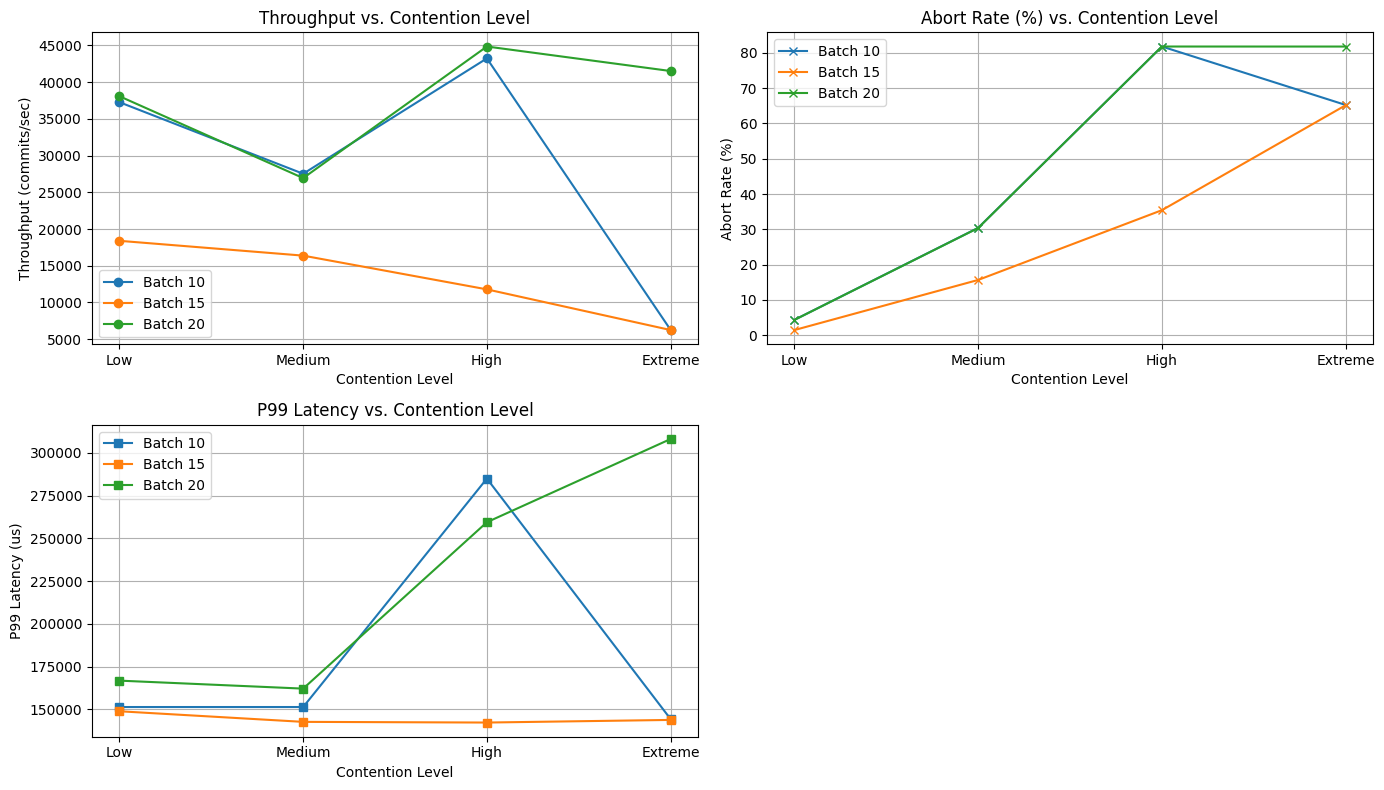

In [10]:
plot_metrics_vs_contention_levels_multiple(
    thresholds=['10', '15', '20'],
    contention_levels=['low_contention', 'medium_contention', 'high_contention', 'extreme_contention']
)